In [1]:
import sys
sys.path.insert(0, "/home/tfioratti/git/stockora/")
from stockora.shadow_clone import parallelize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def dsigmoid_from_val(s):
    return s * (1.0 - s)

def dtanh_from_val(t):
    return 1.0 - t*t

def make_Us(N, g=1.0, seed_J=0):
    rng = np.random.RandomState(seed_J)
    scale = g / np.sqrt(N)
    U_i =  rng.randn(N, N) / np.sqrt(N) * g
    U_f =  rng.randn(N, N)  / np.sqrt(N) * g
    U_o =  rng.randn(N, N)  / np.sqrt(N) * g
    U_g = scale * rng.randn(N, N)
    return U_i, U_f, U_o, U_g

def make_biases(N, sigma_b=0.0, seed_b=1):
    rng = np.random.RandomState(seed_b)
    b_i = sigma_b * rng.randn(N)
    b_f = sigma_b * rng.randn(N)
    b_o = sigma_b * rng.randn(N)
    b_g = sigma_b * rng.randn(N)*0
    return b_i, b_f, b_o, b_g

def make_biases_chrono(N, sigma_b=0.0, seed_b=1):
    rng = np.random.default_rng(seed_b)
    sigma_tilde = rng.uniform(2.0 + 1e-6, sigma_b, size=N)   
    bf =  np.log(sigma_tilde - 1.0)      
    bi = -bf                             
    bo = np.zeros(N)                    
    bg = np.zeros(N)                     
    return bi, bf, bo, bg

def make_h0c0(N, scale_h=0.1, scale_c=0.1, seed=2):
    rng = np.random.RandomState(seed)
    h0 = scale_h * rng.randn(N)
    c0 = scale_c * rng.randn(N)
    return h0, c0

def make_v0(N, seed=3):
    rng = np.random.RandomState(seed)
    dh = rng.randn(N)
    dc = rng.randn(N)
    v  = np.concatenate([dh, dc])
    return v / (np.linalg.norm(v) + 1e-32)

def lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g):
    z_i = U_i @ h + b_i
    z_f = U_f @ h + b_f
    z_o = U_o @ h + b_o
    z_g = U_g @ h + b_g

    i = sigmoid(z_i)
    f = sigmoid(z_f)
    o = sigmoid(z_o)
    g = np.tanh(z_g)

    c_new = f * c + i * g
    h_new = o * np.tanh(c_new)

    cache = {"i": i, "f": f, "o": o, "g": g, "c_prev": c, "c": c_new}
    return h_new, c_new, cache

def lstm_tangent_jvp(dh, dc, cache, U_i, U_f, U_o, U_g):
    i = cache["i"]; f = cache["f"]; o = cache["o"]; g = cache["g"]
    c_prev = cache["c_prev"]; c = cache["c"]

    di = dsigmoid_from_val(i) * (U_i @ dh)
    df = dsigmoid_from_val(f) * (U_f @ dh)
    do = dsigmoid_from_val(o) * (U_o @ dh)
    dg = dtanh_from_val(g)     * (U_g @ dh)

    dc_new = df * c_prev + f * dc + di * g + i * dg
    tanh_c = np.tanh(c)
    dh_new = do * tanh_c + o * dtanh_from_val(tanh_c) * dc_new
    return dh_new, dc_new

def compute_trajectory_lstm(Us, bs, g, dt, T, warmup, h0, c0, record_stride=1):
    
    steps_warm = int(np.round(warmup / dt))
    steps_sim  = int(np.round(T / dt))
    U_i, U_f, U_o, U_g = Us
    b_i, b_f, b_o, b_g = bs

    h = h0.copy(); c = c0.copy(); t = 0.0
    for _ in range(steps_warm):
        h, c, _ = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)
        t += dt

    S  = steps_sim // record_stride
    Hs = np.empty((S, h.size))
    Cs = np.empty((S, c.size))
    ts = np.empty(S)
    k  = 0
    for s in range(steps_sim):
        h, c, _ = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)
        t += dt
        if (s + 1) % record_stride == 0:
            Hs[k] = h; Cs[k] = c; ts[k] = t; k += 1
    return Hs, Cs, ts

def init(bf, bi, bo, bg):
    f = sigmoid(bf); i = sigmoid(bi); o = sigmoid(bo); g = np.tanh(bg)
    c_star = (i*g) / (1 - f + 1e-12)
    h_star = o * np.tanh(c_star)
        
    return h_star, c_star

def compute_lyapunov_lstm(Us, bs, g, dt, T, warmup, h0, c0, v0,
                          reorth_every=10, eps0=1e-7):
  
    steps_warm = int(np.round(warmup / dt))
    steps      = int(np.round(T / dt))
    U_i, U_f, U_o, U_g = Us
    b_i, b_f, b_o, b_g = bs

    h = h0.copy(); c = c0.copy()
    for _ in range(steps_warm):
        h, c, _ = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)

    N = h.size
    dh = v0[:N].copy()
    dc = v0[N:].copy()
    n0 = np.sqrt(np.linalg.norm(dh)**2 + np.linalg.norm(dc)**2) + 1e-32
    dh *= (eps0 / n0); dc *= (eps0 / n0)

    accum = 0.0
    count = 0

    for s in range(steps):
        h, c, cache = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)
        dh, dc = lstm_tangent_jvp(dh, dc, cache, U_i, U_f, U_o, U_g)

        if (s + 1) % reorth_every == 0:
            norm_v = np.sqrt(np.linalg.norm(dh)**2 + np.linalg.norm(dc)**2) + 1e-32
            accum += np.log(norm_v / eps0)
            count += 1
            dh *= (eps0 / norm_v)
            dc *= (eps0 / norm_v)

    return (accum / (count * reorth_every)) / dt if count > 0 else float('nan')

def plot_traces(ts, Hs, max_traces=5, title=None):
    idx = np.arange(min(max_traces, Hs.shape[1]))
    plt.figure(figsize=(8,4.5))
    for i in idx:
        plt.plot(ts, Hs[:, i], label=f"h[{i}]")
    plt.xlabel("time"); plt.ylabel("h_t")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3)
    if len(idx) <= 10: plt.legend()
    plt.show()

def plot_lyapunov(g_vals, lam_vals, title=None):
    plt.figure(figsize=(8,4.5))
    plt.plot(g_vals, lam_vals, marker="o")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("g")
    plt.ylabel("Largest Lyapunov exponent (1/time)")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()



In [ ]:
dt        = 0.05
T         = 200
warmup    = 20.0
N_vals = [256, 512, 1024, 2048]          
N_vals = sorted(N_vals)           
N_max  = N_vals[-1]               

g_vals = np.linspace(1, 3.0, 19)  
lam_curves = {}                   


Us_big = make_Us(N_max, seed_J=15) #19
bs_big = make_biases_chrono(N_max, sigma_b=10, seed_b=1)

h0_big, c0_big =  make_h0c0(N_max, scale_h=0.5, scale_c=0.5, seed=2)
v0_big =  make_v0(N_max, seed=2)

def cut_matrices(U_list, N):
    scale = np.sqrt(N_max / N)
    return [scale * U[:N, :N] for U in U_list]

def cut_vectors(vec, N):
    return vec[:N]

def cut_biases(bias_list, N):
    return [b[:N] for b in bias_list]


for N in N_vals:

    Us = cut_matrices(Us_big, N)
    bs = cut_biases(bs_big, N)
    h0 = cut_vectors(h0_big, N)
    c0 = cut_vectors(c0_big, N)
    v0 = cut_vectors(v0_big, 2*N)

    lam_vec = np.empty(len(g_vals))
    for i, g in enumerate(g_vals):
        Us_g = tuple(g * U for U in Us)   
        lam   = compute_lyapunov_lstm(
                    Us_g, bs, 1, dt, T, warmup,
                    h0, c0, v0,
                    reorth_every=10, eps0=1e-6
                )
        lam_vec[i] = lam

    lam_curves[N] = lam_vec    



In [ ]:
lam_matrix = np.vstack([lam_curves[N] for N in N_vals])  

np.savez("lyap_data.npz",
         g_vals   = g_vals,
         N_vals   = np.array(N_vals),
         lam_mat  = lam_matrix)

In [193]:
print(lam_curves)

{256: array([-1.47962482, -1.34466047, -1.20095417, -1.05047098, -0.8948801 ,
       -0.73505629, -0.57088192, -0.40085704, -0.21774129, -0.01308361,
       -0.02447392, -0.00741464,  0.12636267,  0.25047631,  0.29503831,
        0.39714104,  0.49343317,  0.55346479,  0.65399364]), 512: array([-1.48449406, -1.34557312, -1.20119934, -1.05162635, -0.89854574,
       -0.74412408, -0.58986756, -0.43970964, -0.29553222, -0.09471094,
        0.09276816,  0.11981227,  0.22026781,  0.31834505,  0.43894858,
        0.49185722,  0.57789647,  0.67248437,  0.79154256]), 1024: array([-1.50012699, -1.36290678, -1.2162375 , -1.06788539, -0.91725741,
       -0.76975051, -0.60357668, -0.412607  , -0.22618293, -0.03693045,
        0.04346875,  0.19615897,  0.30022377,  0.40068488,  0.45943694,
        0.57894051,  0.64716904,  0.71992807,  0.82086274]), 2048: array([-1.46959443, -1.33198178, -1.18242207, -1.03064802, -0.87758733,
       -0.73239069, -0.55267057, -0.37610111, -0.20022566, -0.02298353,
  

/opt/tmp/tmp/ipykernel_1900302/4091978360.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors  = plt.cm.get_cmap('Blues')(np.linspace(0.35, 0.85, len(N_vals)))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


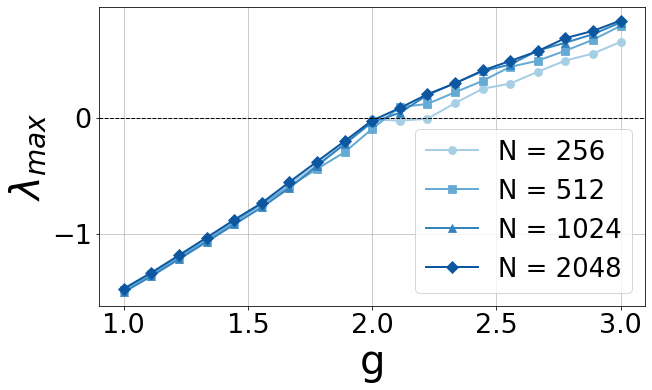

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
N_vals = [256, 512, 1024, 2048]
g_vals = np.linspace(1, 3.0, 19)
colors  = plt.cm.get_cmap('Blues')(np.linspace(0.35, 0.85, len(N_vals)))
markers = ['o', 's', '^', 'D']

for idx, N in enumerate(N_vals):
    ax.plot(g_vals, lam_curves[N],
            marker=markers[idx % len(markers)],
            markersize=8,           
            markeredgewidth=0.8,    
            color=colors[idx],
            linewidth=2,
            label=f"N = {N}")

ax.axhline(0, color='k', linestyle='--', linewidth=1)

ax.set_xlabel("g")
ax.set_ylabel("$\lambda_{max}$")
ax.grid(True, alpha=0.8)
ax.legend()
fig.tight_layout()
plt.savefig("lambda_max_chrono.eps", format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


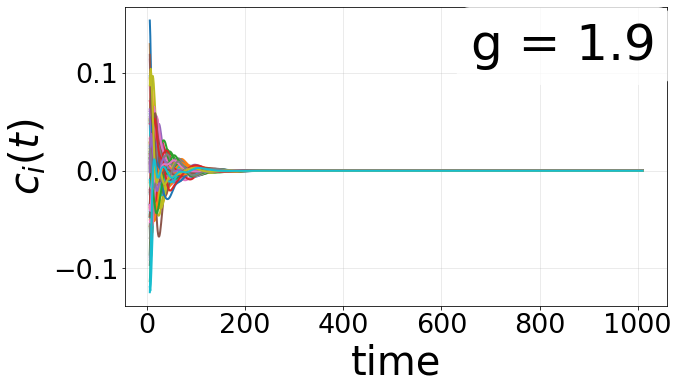

In [ ]:
N          = 4000        
g_demo     = 1.9 
dt         = 1.0
n_traj     =  80 
warmup = 5
T = 1000
#T_crono = 100
seed_base  = 123        
Us = make_Us  (N, g_demo,      seed_J = seed_base)
bs = make_biases(N, sigma_b=0, seed_b = seed_base)
#bf = np.log(T_crono - 1) * np.ones(N)      
#bi = -np.log(T_crono-1)* np.ones(N)     
#bo = np.zeros(N)                
#bg = np.zeros(N)                  

#bs = bi, bf, bo, bg
h0, c0 = make_h0c0(N, scale_h=0.3, scale_c=0.3, seed=seed_base)

Us_scaled = tuple(U for U in Us)

Hs, Cs, ts = compute_trajectory_lstm(
    Us_scaled, bs, g_demo, dt,
    T=T + warmup, warmup=warmup,     
    h0=h0, c0=c0,
    record_stride=1
)                                    

rng = np.random.default_rng(seed_base)         
idxs = rng.choice(N, size=n_traj, replace=False)

plt.figure(figsize=(10, 6))
for k, idx in enumerate(idxs):
    plt.plot(ts, Hs[:, idx])#, label=f"neuron {idx}")

plt.xlabel("time")
plt.ylabel("$c_i(t)$")
plt.grid(True, alpha=0.3)


plt.text(0.98, 0.95,                     
         f"g = {g_demo}",                
         transform=plt.gca().transAxes,  
         ha='right', va='top',           
         fontsize=50,                    
         bbox=dict(boxstyle='round',     
                   facecolor='white',
                   edgecolor='none',
                   alpha=0.8))

plt.tight_layout()
plt.savefig("g199.eps", format='eps', bbox_inches='tight')
plt.show()


In [ ]:
def _split_seeds(seed_J: int):
    base = int(seed_J) & 0xFFFFFFFF
    return {
        'seed_x0': (base + 1) & 0xFFFFFFFF,
        'seed_v0': (base + 2) & 0xFFFFFFFF,
        'seed_b':  (base + 3) & 0xFFFFFFFF,
    }

def find_gc_job_lstm(job, *, N, dt, T, warmup,
                     g_lo=1.7, g_hi=4.0, tol=1e-3, max_iter=10):
    
    sigma_b = float(job['sigma_b'])
    seed_J  = int(job['seed_J'])
    #T = T + 5*sigma_b 
    #warmup = warmup + 5*sigma_b
    seeds = _split_seeds(seed_J)


    Us_base = make_Us(N, g=1.0, seed_J=seed_J)


    h0, c0 = make_h0c0(N, scale_h= 1e-6, scale_c=1e-6, seed=seeds['seed_x0'])
    v0     = make_v0(N, seed=seeds['seed_v0'])
    bs     = make_biases(N, sigma_b=sigma_b, seed_b=seeds['seed_b'])
    #seed_b = int(seeds['seed_b'])
    #rng = np.random.default_rng(seed_b)
    #sigma_tilde = rng.uniform(2.0 + 1e-6, sigma_b, size=N)   
    #bf =  np.log(sigma_tilde - 1.0)      
    #bi = -bf                             
    #bo = np.zeros(N)                     
    #bg = np.zeros(N)                     
    #bs = bi, bf, bo, bg

    def Us_scaled(g):
        return tuple(g * U for U in Us_base)

    lam_lo = compute_lyapunov_lstm(Us_scaled(g_lo), bs, g_lo, dt, T, warmup, h0, c0, v0,
                                   reorth_every=10, eps0=1e-7)
    lam_hi = compute_lyapunov_lstm(Us_scaled(g_hi), bs, g_hi, dt, T, warmup, h0, c0, v0,
                                   reorth_every=10, eps0=1e-7)

    if lam_lo >= 0:
        gc = g_lo
    elif lam_hi <= 0:
        gc = float('nan')
    else:
        lo, hi = g_lo, g_hi
        for _ in range(max_iter):
            mid = 0.5 * (lo + hi)
            lam = compute_lyapunov_lstm(Us_scaled(mid), bs, mid, dt, T, warmup, h0, c0, v0,
                                        reorth_every=10, eps0=1e-7)
            if lam > 0:
                hi = mid
            else:
                lo = mid
            if hi - lo < tol:
                break
        gc = 0.5 * (lo + hi)

    return {'seed_J': seed_J, 'sigma_b': sigma_b, 'g_c': float(gc)}


In [ ]:
N = 4000; dt = 0.05
T = 200.0; warmup = 20
sigma_grid   = np.linspace(0, 1, 20) #sigma_b can be also T_crono
seed_J_list  = list(range(20,24))
print(seed_J_list)

[20, 21, 22, 23]


In [52]:

jobs = [{'seed_J': int(sJ), 'sigma_b': float(s)}
        for sJ in seed_J_list
        for s in sigma_grid]

results = parallelize(
    exec_func=find_gc_job_lstm,   
    jobs=jobs,
    single_arg=True,
    exec_kwargs=dict(
        N=N, dt=dt, T=T, warmup=warmup,
        g_lo=0, g_hi=2.5, tol=1e-4, max_iter=10
    ),
    mode="slurm",
    wait_for_graph_execution=False,
    root_dir="/mnt/live/user/tfioratti/gc_parallel_J_sigma_lstm",
)


Saving datatree in /mnt/live/user/tfioratti/gc_parallel_J_sigma_lstm/_inputs/exec_kwargs
Datatree saved in /mnt/live/user/tfioratti/gc_parallel_J_sigma_lstm/_inputs/exec_kwargs
Estimating memory for new tasks from graph local data
[tfioratti__gc_parallel_J_sigma_lstm] Done adding the graph


Graph tfioratti__gc_parallel_J_sigma_lstm posted. Follow the execution using the [grid view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/manage/tfioratti__gc_parallel_J_sigma_lstm) or the [graph view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/display/tfioratti__gc_parallel_J_sigma_lstm)

[AUDIT][tfioratti__gc_parallel_J_sigma_lstm] Start graph


In [53]:
import json
from pathlib import Path
results_dir = Path("/mnt/live/user/tfioratti/gc_parallel_J_sigma_lstm/execution_results")

data_dict = {}

for result_file in results_dir.glob("*.json"):  
    with open(result_file, 'r') as file:
        data = json.load(file)
    tau_value = data  
    file_key = result_file.stem
    data_dict[file_key] = tau_value


In [ ]:
seeds = sorted({v['seed_J'] for v in data_dict.values()})
sigma_b_values = sorted({v['sigma_b'] for v in data_dict.values()})


seed_index = {seed: i for i, seed in enumerate(seeds)}
sigma_b_index = {sigma: i for i, sigma in enumerate(sigma_b_values)}

g_c_array = np.empty((len(seeds), len(sigma_b_values)))
g_c_array.fill(np.nan) 


for item in data_dict.values():
    seed = item['seed_J']
    sigma_b = item['sigma_b']
    g_c = item['g_c']
    i = seed_index[seed]
    j = sigma_b_index[sigma_b]
    g_c_array[i, j] = g_c

g_c_empirical = np.mean(g_c_array, axis = 0)
print(g_c_empirical)
err = 1.96*np.std(g_c_array, axis = 0)/np.sqrt(len(seed_J_list))
print(err)

[2.00134277 2.00378418 2.00378418 1.99768066 1.96411133 1.92138672
 1.90673828 1.89331055 1.83410645 1.76025391 1.74255371 1.66137695
 1.6027832  1.5423584  1.60095215 1.49963379 1.34155273 1.27502441
 1.22497559 1.22924805]
[0.01832901 0.0212236  0.02771546 0.03696417 0.02743652 0.02335063
 0.03522457 0.05106347 0.03594346 0.00993712 0.07670023 0.07071273
 0.07747299 0.09817409 0.07033478 0.11556889 0.12787429 0.1352111
 0.14912284 0.12258315]


In [55]:
np.savez('g_lam0_sigmab_init.npz',
         g_c_array=g_c_array,
         g_c_empirical=g_c_empirical,
         err=err)

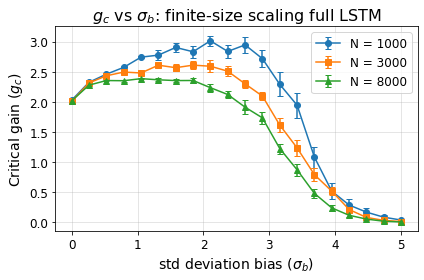

In [ ]:
d1000 = np.load('f_1000.npz')
d3000 = np.load('f_3000.npz')
d8000 = np.load('f_8000.npz')

sigma_b = d1000['sigma_b']        

fig, ax = plt.subplots(figsize=(6, 4))

ax.errorbar(sigma_b, d1000['g_c'], yerr=d1000['error'],
            fmt='o-', capsize=3, label='N = 1000')
ax.errorbar(sigma_b, d3000['g_c'], yerr=d3000['error'],
            fmt='s-', capsize=3, label='N = 3000')
ax.errorbar(sigma_b, d8000['g_c'], yerr=d8000['error'],
            fmt='^-', capsize=3, label='N = 8000')

ax.set_title(r"$g_c$ vs $\sigma_b$: finite-size scaling full LSTM",
             fontsize=16)
ax.set_xlabel(r"std deviation bias ($\sigma_b$)", fontsize=14)
ax.set_ylabel(r"Critical gain ($g_c$)",            fontsize=14)
ax.grid(True, alpha=0.4)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()

fig.savefig("gc_finite_size.png", dpi=300, bbox_inches="tight")

plt.show()